In [1]:
#################################################################
#
# Estimate pendulum state with GHKF and GHRTS as in Examples 6.1
# and 10.1 of the book
#
# Simo Sarkka (2013), Bayesian Filtering and Smoothing,
# Cambridge University Press. 
#
# Last updated: $Date: 2013/08/26 12:58:41 $.
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.
#
#################################################################

In [2]:
import numpy as np
from numpy.linalg import cholesky, solve

import plotly.graph_objects as go
from plotly.subplots import make_subplots

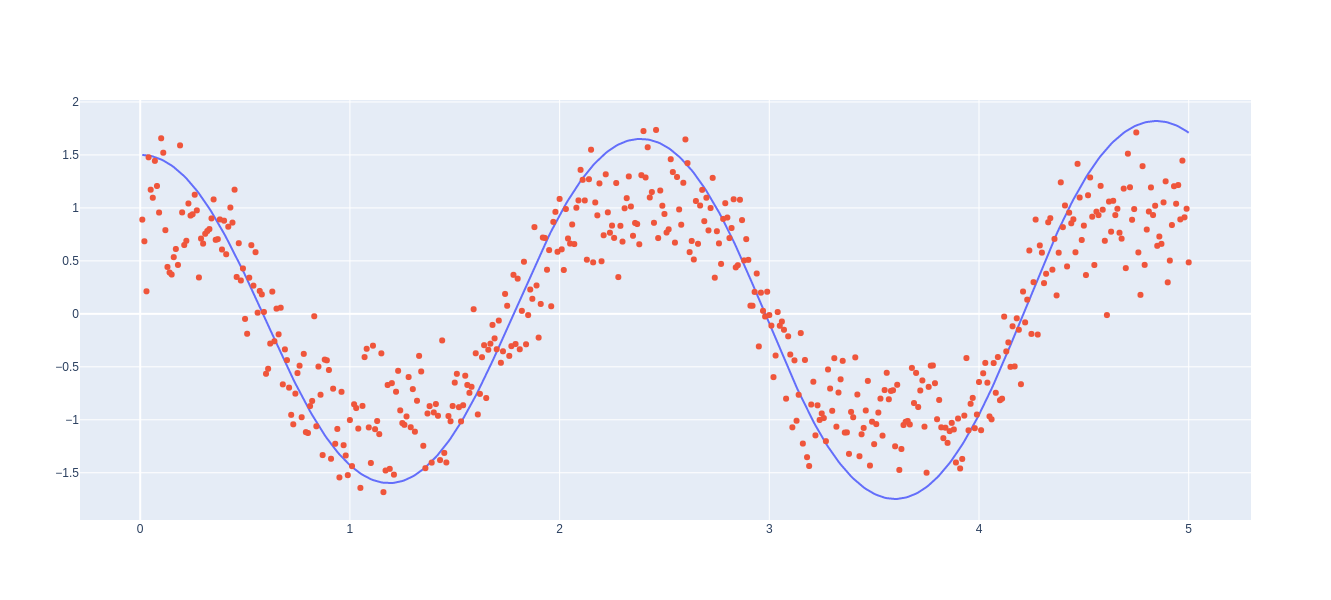

In [3]:
##
# Simulate data
##
from pendulum_sim import dt, T, m0, P0, Q, R, g, Y, X

In [4]:
##
# Filter
##

m = m0
P = P0

p = 5       # Order of the method
n = m.shape[0]
y_ = len(Y)
p_1, p_2 = P.shape


# Form Probabilists' Hermite polynomials of
# order p-1 and p
Hpm = 1
Hp  = np.array([1, 0])
for i in range(1,p):
    tmp = Hp
    Hp = np.hstack([Hp, 0]) - np.hstack([0, 0, i*Hpm])
    Hpm = tmp


# Single dimensional weights and points
xi1 = np.roots(Hp)
W1 = np.math.factorial(p)/(p**2*np.polyval(Hpm,xi1)**2)

#Generate all p**n collections of indexes by
#transforming numbers 0...p**n-1) into p-base system
#and by adding 1 to each digit
num = np.arange(p**n)
ind = np.zeros((n,p**n), dtype=int)
for i in range(n):
    ind[i] = num % p
    num //= p

# Form the unit sigma points and weights
XI = xi1[ind]
W = np.prod(W1[ind], axis=0)[:,None]    # ND weights

In [5]:
# Do the filtering 
MM = np.zeros((y_,n,1))
PP = np.zeros((y_,p_1,p_2))
for k in range(y_):

    # Form the sigma points for dynamic model
    SX = np.tile(m,XI.shape[1]) + cholesky(P) @ XI

    # Propagate through the dynamic model
    HX = np.array([SX[0]+SX[1]*dt, SX[1]-g*np.sin(SX[0])*dt])

    # Compute the predicted mean and covariance
    m = HX@W
    P = W.T*(HX-m) @ (HX-m).T + Q

    # Form sigma points for measurement step and
    # propagate throught the measurement model
    SX = np.tile(m,XI.shape[1]) + cholesky(P) @ XI
    HY = np.sin(SX[0])[None]

    # Compute the updated mean and covariance
    mu = HY@W
    S = W.T * (HY-mu) @ (HY-mu).T + R
    C = W.T * (SX-m) @ (HY-mu).T

    # Compute the gain and updated mean and covariance  
    K = solve(S.T, C.T).T
    m += K@(Y[k] - mu)
    P -= K@S@K.T

    MM[k] = m
    PP[k] = P


rmse_ghkf = np.sqrt(np.mean((X[:,0,0]-MM[:,0,0])**2))
rmse_ghkf

0.05036708034569549

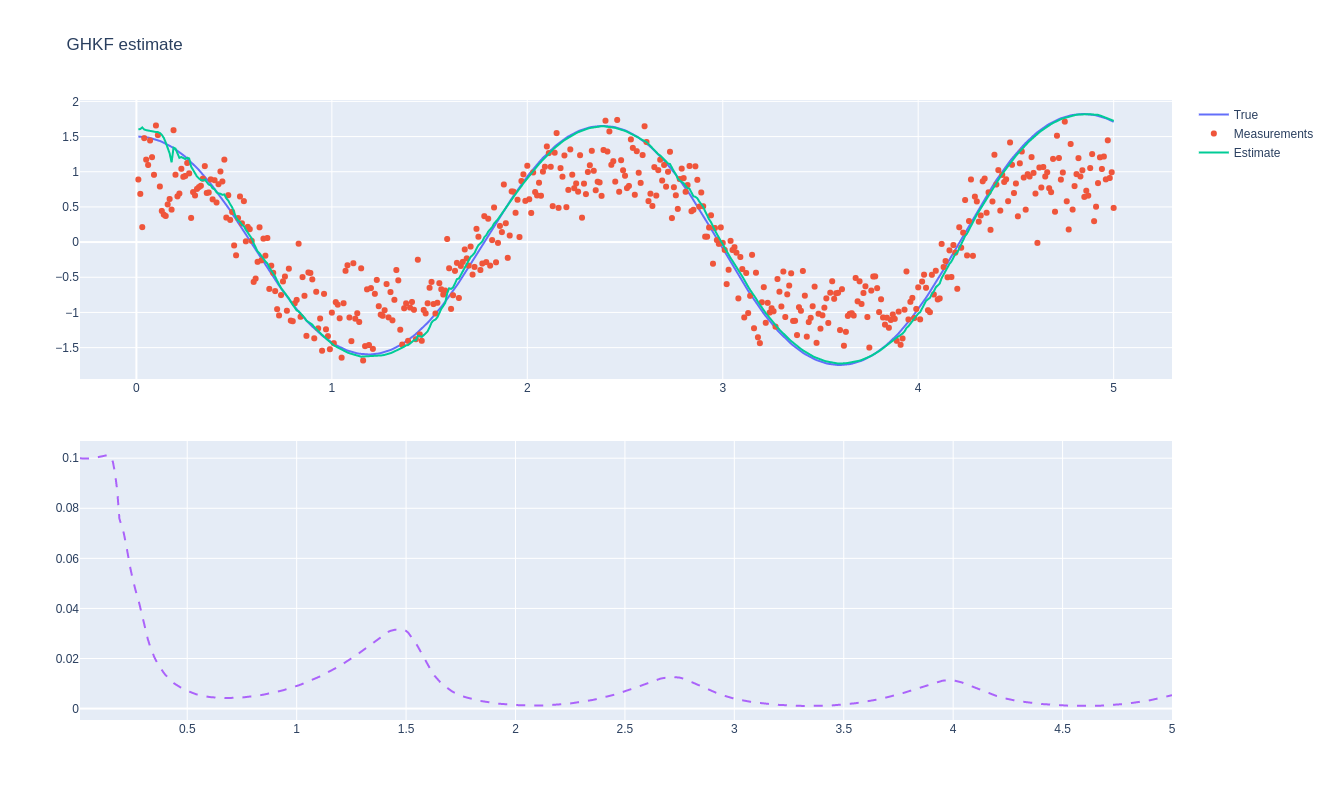

In [6]:
fig = go.Figure(make_subplots(rows=2,cols=1, vertical_spacing=0.1))
fig.add_scatter(x=T, y=X[:,0,0], name='True', row=1, col=1)
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements', row=1, col=1)
fig.add_scatter(x=T, y=MM[:,0,0], name='Estimate', row=1, col=1)
fig.add_scatter(x=T, y=PP[:,0,0], line_dash='dash', showlegend=False, row=2, col=1)
fig.layout.update(title='GHKF estimate', height=800)
fig.show()

In [7]:
##
# Smoother
##

ms = m
Ps = P
MMS = np.zeros((y_,n,1))
PPS = np.zeros((y_,p_1,p_2))
MMS[k] = m
PPS[k] = P
for k in range(y_-2,-1,-1):
    m = MM[k]
    P = PP[k]

    # Form the sigma points for dynamic model
    SX = np.tile(m,XI.shape[1]) + cholesky(P) @ XI

    # Propagate through the dynamic model
    HX = np.array([SX[0]+SX[1]*dt, SX[1]-g*np.sin(SX[0])*dt])

    # Compute the predicted mean and covariance
    # and the cross-covariance D.
    mp = HX@W
    Pp = W.T * (HX-mp) @ (HX-mp).T + Q
    D  = W.T * (SX-m) @ (HX-mp).T

    Ck = solve(Pp.T, D.T).T
    ms = m + Ck @ (ms-mp)
    Ps = P + Ck @ (Ps-Pp) @ Ck.T
    MMS[k] = ms
    PPS[k] = Ps


rmse_ghrts = np.sqrt(np.mean((X[:,0,0]-MMS[:,0,0])**2))
rmse_ghrts

0.02154611348286851

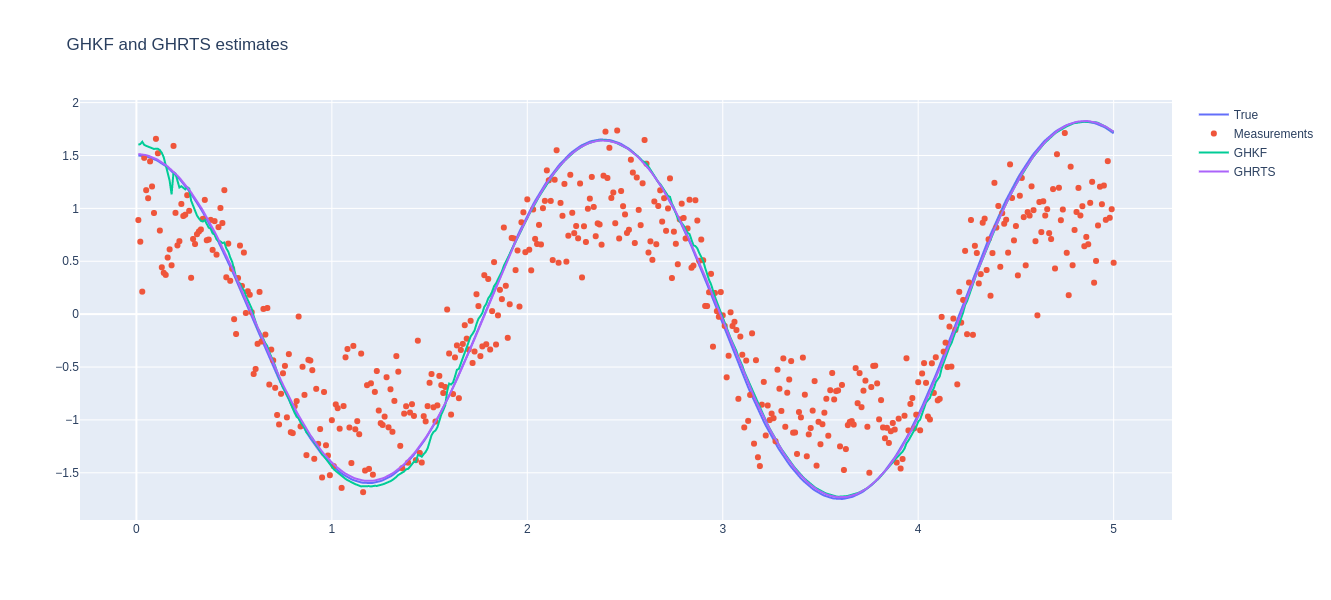

In [8]:
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MM[:,0,0], name='GHKF')
fig.add_scatter(x=T, y=MMS[:,0,0], name='GHRTS')
fig.layout.update(title='GHKF and GHRTS estimates', height=600)
fig.show()

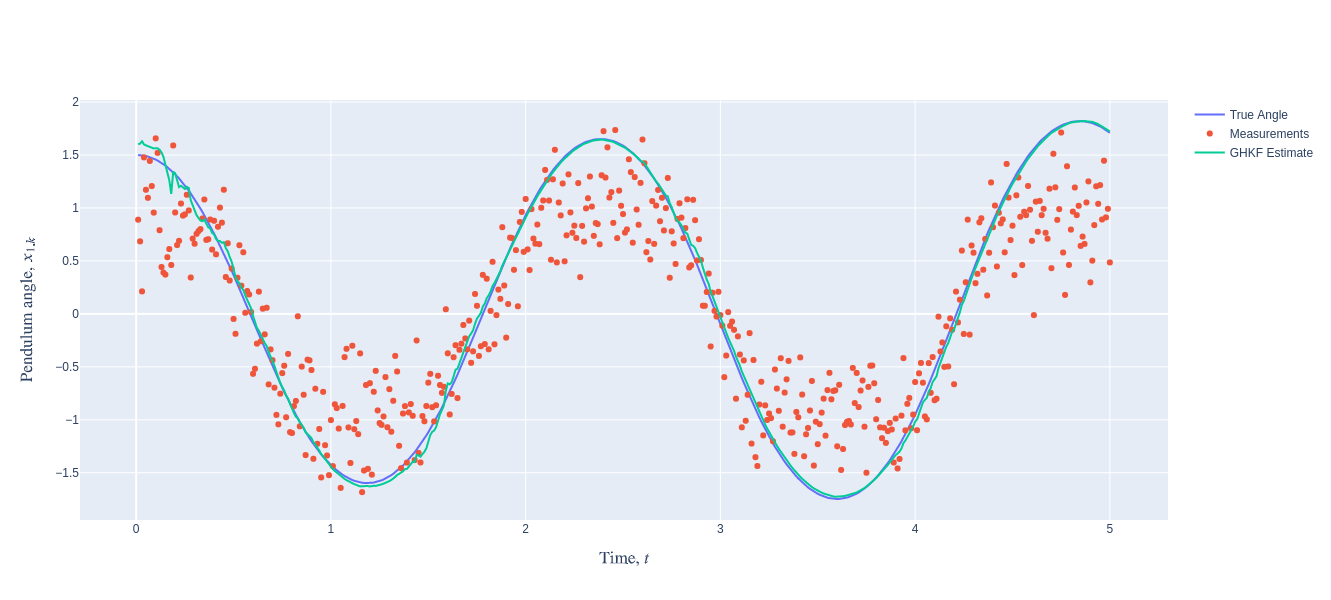

In [9]:
# Plot the filtering result
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True Angle')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MM[:,0,0], name='GHKF Estimate')
fig.layout.update(xaxis_title='$\\text{Time, }t$', yaxis_title='$\\text{Pendulum angle, }x_{1,k}$', height=600)
fig.show()

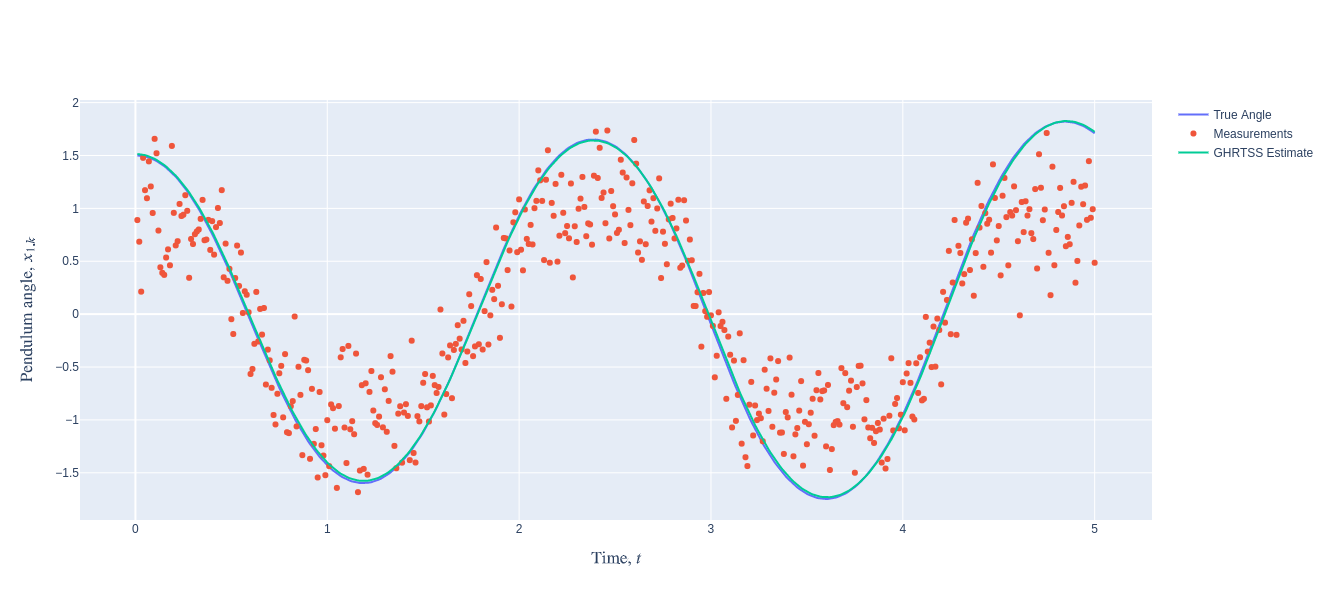

In [10]:
# Plot the smoothing result
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True Angle')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MMS[:,0,0], name='GHRTSS Estimate')
fig.layout.update(xaxis_title='$\\text{Time, }t$', yaxis_title='$\\text{Pendulum angle, }x_{1,k}$', height=600)
fig.show()